# 3. EDA for weather.csv

In this notebook, we will conduct exploratory data analysis of the weather dataset. Specifically, these are the steps that we will undertake:
1. Run through and remove redundant columns 
- Clean the relevant columns and impute null values
- Conduct feature engineering where applicable 
- Visualise and compare relevant data to the west nile virus target variable (Wnvpresent in train set)

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# read dataset
weather = pd.read_csv('../assets/weather.csv')
weather.shape

(2944, 22)

In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [4]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
weather.duplicated().sum()

0

## 3.1 Removing redundant columns

A two-prong approach will be used to remove redundant columns:
- Removal of columns based on limited domain knowledge (likely that temperature and humidity are more important)
- Removal of columns with too many missing values

In [6]:
# Set option so we can view all columns
pd.set_option('display.max_columns',100)

### 3.1.1 Removing columns with missing value

In [7]:
# Every row is a missing value
weather.Water1.value_counts()

M    2944
Name: Water1, dtype: int64

In [8]:
# Drop Water1 column as it contains all missing values M
weather.drop(columns='Water1', inplace=True)
# Ensure Water1 column is removed
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

### 3.1.2 Removing redundant columns

Firstly, we choose to remove the following redundant columns so our analysis can be more focused:  
- 'Sunrise', 'Sunset','StnPressure',''SeaLevel','ResultSpeed','ResultDir', 'AvgSpeed','CodeSum','Depart'
- 'Heat','Cool','Depth','SnowFall'

Specifically, we want to narrow our analysis on the variables concerning temperature and humidity. The reason why heating degree days and cooling degree days are dropped, is due to them being more applicable to the energy expenditure usage. For our purposes, the other variables that capture temperature will be good enough.

In [9]:
to_drop = ['Sunrise', 'Sunset','StnPressure','SeaLevel','ResultSpeed','ResultDir','AvgSpeed','CodeSum','Depart',
          'Heat','Cool','Depth','SnowFall']
weather.drop(columns=to_drop, inplace=True)

## 3.2 Cleaning and value imputation

In this section, we check for missing values and impute where applicable

In [10]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'PrecipTotal'],
      dtype='object')

In [11]:
# It seems like there is no missing value. However, the data description includes that 'M' as a value
# stands for missing value
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
PrecipTotal    0
dtype: int64

### 3.2.1 Imputing WetBulb temperature

In [12]:
# The mean value for wetbulb is ~59 Farenheit
weather.WetBulb.replace({'M':0}).astype(int).mean()

59.23029891304348

In [13]:
# There are 4 missing values for WetBulb
weather.WetBulb.value_counts()['M']

4

In [14]:
# Impute these 4 missing values with mean, as 0 would not make sense for farenheit
weather.WetBulb = weather.WetBulb.replace({'M':59})
# Convert the datatype to interger
weather.WetBulb = weather.WetBulb.astype(int)

### 3.2.2 Imputing average temperature

There are 11 missing values in Tavg. However, this can be easily calculated by taking the average of the Tmin and Tmax. Over here, we will conduct a manual calculation and change Tavg to the float value to increase accuracy and impute missing values.

In [15]:
# (Tmax + Tmin)/2 = Tavg 
weather[['Tmin','Tmax','Tavg']].head()

,Tmin,Tmax,Tavg
0,50,83,67
1,52,84,68
2,42,59,51
3,43,60,52
4,46,66,56


In [16]:
# There are 11 M values in Tavg
weather.Tavg.value_counts()['M']

11

In [17]:
weather.Tavg = (weather.Tmax + weather.Tmin)/2
weather.Tavg = weather.Tavg.astype(float)

In [18]:
# Ascertain that Tavg has been successfully calculated
weather.Tavg.head()

0    66.5
1    68.0
2    50.5
3    51.5
4    56.0
Name: Tavg, dtype: float64

### 3.2.3 Imputing total precipitation

In [19]:
# Rows of data with trace amount of precipitation
weather.PrecipTotal.value_counts()['  T']

318

In [20]:
# Rows of data with missing values
weather.PrecipTotal.value_counts()['M']

2

In [21]:
# Replace Trace amount with 0, replace missing value with mode, also 0
weather.PrecipTotal.replace(['  T','M'],0,inplace=True)

### 3.2.4 Changing data to appropriate datatype

In [22]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   int64  
 7   PrecipTotal  2944 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 184.1+ KB


In [23]:
# Converted the data to the appropriate datatype
weather.Date = weather.Date.astype('datetime64[ns]')
weather.PrecipTotal = weather.PrecipTotal.astype(float)

## 3.3 Feature engineering

Narrowing our focus onto humidity and temperature, the following are features that we will be engineering using the existing data:
- Relative humidity (Using DewPoint and WetBulb)
- Temperature range (Using Tmax and Tmin)
- Isolating year, month, week and day
- 7 day rolling precipitation average (Using PrecipTotal)

### 3.3.1 Relative Humidity

In [24]:
weather.loc[:,['Tavg','DewPoint']]

,Tavg,DewPoint
0,66.5,51
1,68.0,51
2,50.5,42
3,51.5,42
4,56.0,40
...,...,...
2939,44.5,34
2940,41.5,34
2941,45.0,35
2942,40.0,25


In [25]:
# Function to calculate relative humidity
def relative_humidity(tavg,dewpoint):
    # Formula to convert temperature from Farenheit to celsius : Tc=5.0/9.0x(Tf-32.0) 
    # Formula to convert dewpoint from Farenheit to celsius : Tdc=5.0/9.0x(Tdf-32.0)
    tavg_celcius = (5.0/9.0)*(tavg-32.0)
    dewpoint_celcius = (5.0/9.0)*(dewpoint-32.0)
    
    # 6.11x10.0x(7.5xTc/(237.7+Tc)) for actual vapor pressure 
    # and 6.11x10.0x(7.5xTdc/(237.7+Tdc)) for saturated vapor pressure.
    saturation_vapour_pressure = 6.11*10.0*(7.5*tavg_celcius/(237.7+tavg_celcius))
    actual_pressure = 6.11*10.0*(7.5*dewpoint_celcius/(237.7+dewpoint_celcius))
    
    # Divide actual vapor pressure by saturation vapor pressure and 
    # multiply by 100 to obtain a percentage using the formula Relative Humidity
    return round(((actual_pressure/saturation_vapour_pressure)*100))



In [26]:
# New column with relative humidity values are created from the function
weather['relative_humidity']=relative_humidity(weather['Tavg'],weather['DewPoint']).astype(int)

weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,relative_humidity
0,1,2007-05-01,83,50,66.5,51,56,0.0,57
1,2,2007-05-01,84,52,68.0,51,57,0.0,55
2,1,2007-05-02,59,42,50.5,42,47,0.0,55
3,2,2007-05-02,60,43,51.5,42,47,0.0,52
4,1,2007-05-03,66,46,56.0,40,48,0.0,35


### 3.3.2 Temperature range

In [27]:
weather['Trange'] = weather['Tmax'] - weather['Tmin']

In [28]:
weather['Trange'].head()

0    33
1    32
2    17
3    17
4    20
Name: Trange, dtype: int64

### 3.3.3 Extracting year, month, week, day

In [29]:
weather['Year'] = weather.Date.apply(lambda x:x.year)
weather['Month'] = weather.Date.apply(lambda x:x.month)
weather['Week'] = weather.Date.apply(lambda x:x.week)
weather['Day'] = weather.Date.apply(lambda x:x.day)

### 3.3.4 7 Day Rolling Average Precipitation

One of the dilemmas faced during the engineering of the 7 day rolling average for precipitation is the fact that doing so will create a column with (7-1=6) NaN values per station due to the fact that the rolling average takes into account previous datasets. As such, we decide to impute the NaN values as 0 for the following reason:
- The PrecipTotal value is 0.0 for most of that particular week
- The removal of the rows of data with the NaN are accorded a heavier penalty

Therefore, we decide to go with such an imputation process.

In [30]:
# Code for 7 day rolling average for station 1 
station1_df = weather[weather.Station == 1]
station1_7D_prep_avg = pd.DataFrame(weather[weather.Station == 1].PrecipTotal.rolling(7).mean())
station1_7D_prep_avg.rename(columns={'PrecipTotal':'precip_7D_avg'},inplace=True) 
station1_combined = pd.merge(station1_df,station1_7D_prep_avg,left_index=True,right_index=True)

In [31]:
# Seeing that PrecipTotal for first 7 days of may is 0, and choosing to weigh the consequences of dropping
# the 7 NaN columns, we decide to impute the NaN values with 0, accepting that it may causes slight inaccuracy 
# in the data
station1_combined.fillna(value=0,inplace=True)

In [32]:
# Code for 7 day rolling average for station 2 
station2_df = weather[weather.Station == 2]
station2_7D_prep_avg = pd.DataFrame(weather[weather.Station == 2].PrecipTotal.rolling(7).mean())
station2_7D_prep_avg.rename(columns={'PrecipTotal':'precip_7D_avg'},inplace=True) 
station2_combined = pd.merge(station2_df,station2_7D_prep_avg,left_index=True,right_index=True)

In [33]:
# Seeing that PrecipTotal for first 7 days of may is 0, and choosing to weigh the consequences against dropping
# the 7 NaN columns, we decide to impute the NaN values with 0, accepting that it may causes slight inaccuracy 
# in the data
station2_combined.fillna(value=0,inplace=True)

In [34]:
weather = pd.concat([station1_combined,station2_combined]).sort_index()

In [35]:
# 7 day rolling average successfully engineered
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,relative_humidity,Trange,Year,Month,Week,Day,precip_7D_avg
0,1,2007-05-01,83,50,66.5,51,56,0.0,57,33,2007,5,18,1,0.0
1,2,2007-05-01,84,52,68.0,51,57,0.0,55,32,2007,5,18,1,0.0
2,1,2007-05-02,59,42,50.5,42,47,0.0,55,17,2007,5,18,2,0.0
3,2,2007-05-02,60,43,51.5,42,47,0.0,52,17,2007,5,18,2,0.0
4,1,2007-05-03,66,46,56.0,40,48,0.0,35,20,2007,5,18,3,0.0
5,2,2007-05-03,67,48,57.5,40,50,0.0,33,19,2007,5,18,3,0.0
6,1,2007-05-04,66,49,57.5,41,50,0.0,37,17,2007,5,18,4,0.0
7,2,2007-05-04,78,51,64.5,42,50,0.0,32,27,2007,5,18,4,0.0
8,1,2007-05-05,66,53,59.5,38,49,0.0,23,13,2007,5,18,5,0.0
9,2,2007-05-05,66,54,60.0,39,50,0.0,26,12,2007,5,18,5,0.0


## 3.4 Data visualisation

In [36]:
weather[weather.Station == 1]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,relative_humidity,Trange,Year,Month,Week,Day,precip_7D_avg
0,1,2007-05-01,83,50,66.5,51,56,0.00,57,33,2007,5,18,1,0.000000
2,1,2007-05-02,59,42,50.5,42,47,0.00,55,17,2007,5,18,2,0.000000
4,1,2007-05-03,66,46,56.0,40,48,0.00,35,20,2007,5,18,3,0.000000
6,1,2007-05-04,66,49,57.5,41,50,0.00,37,17,2007,5,18,4,0.000000
8,1,2007-05-05,66,53,59.5,38,49,0.00,23,13,2007,5,18,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,1,2014-10-27,77,51,64.0,51,58,0.00,61,26,2014,10,44,27,0.000000
2936,1,2014-10-28,68,45,56.5,38,47,0.00,26,23,2014,10,44,28,0.000000
2938,1,2014-10-29,49,36,42.5,32,40,0.00,0,13,2014,10,44,29,0.000000
2940,1,2014-10-30,51,32,41.5,34,40,0.00,21,19,2014,10,44,30,0.000000


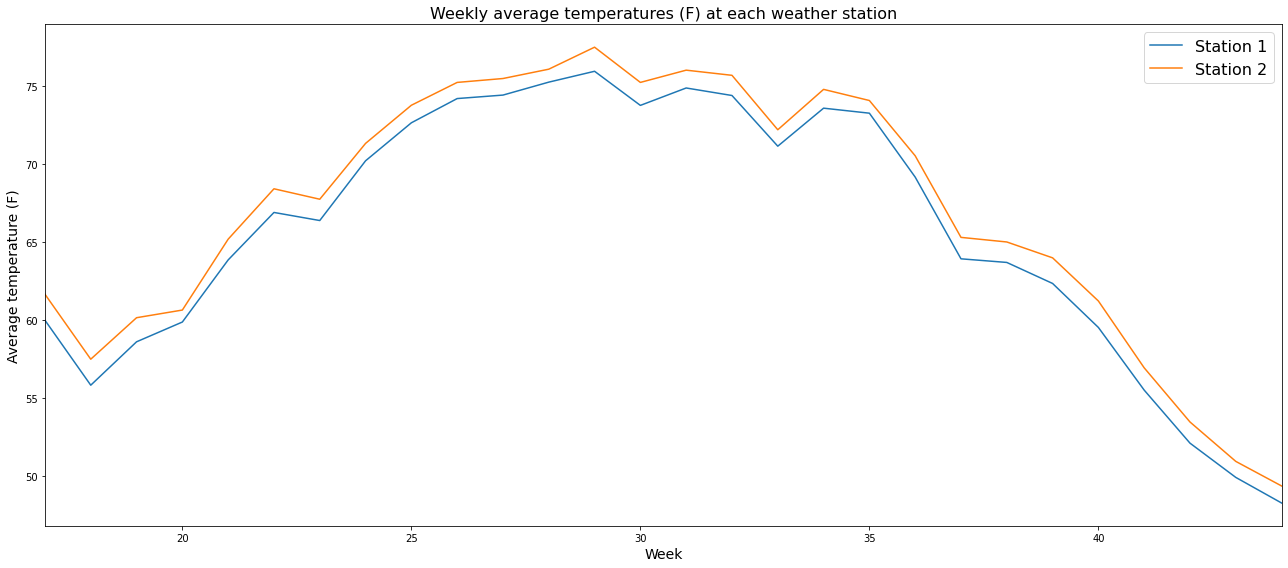

In [37]:
# plot weekly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'Week',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 16)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.Week.min(), weather.Week.max())
plt.tight_layout()

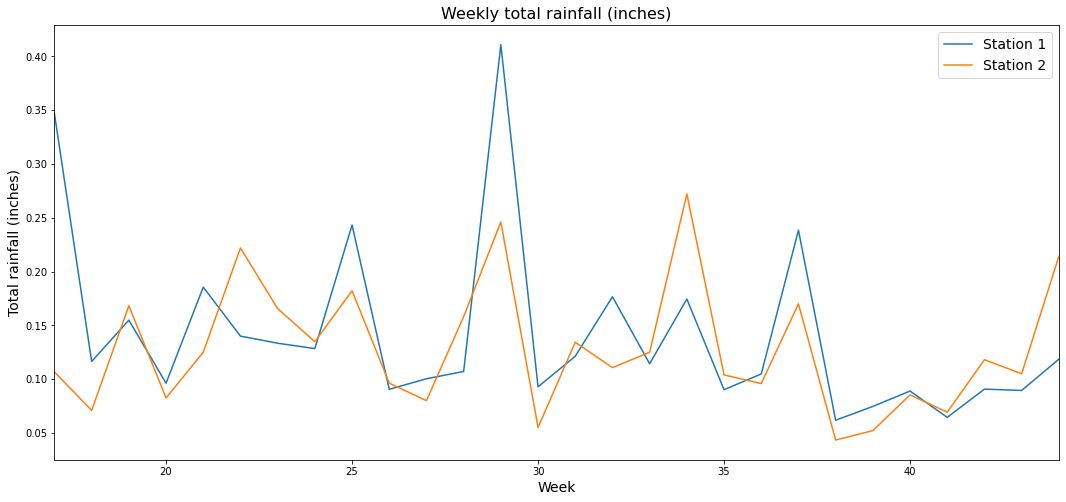

In [38]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'Week',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches)', fontsize=16)
plt.xlabel('Week',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.Week.min(), weather.Week.max());


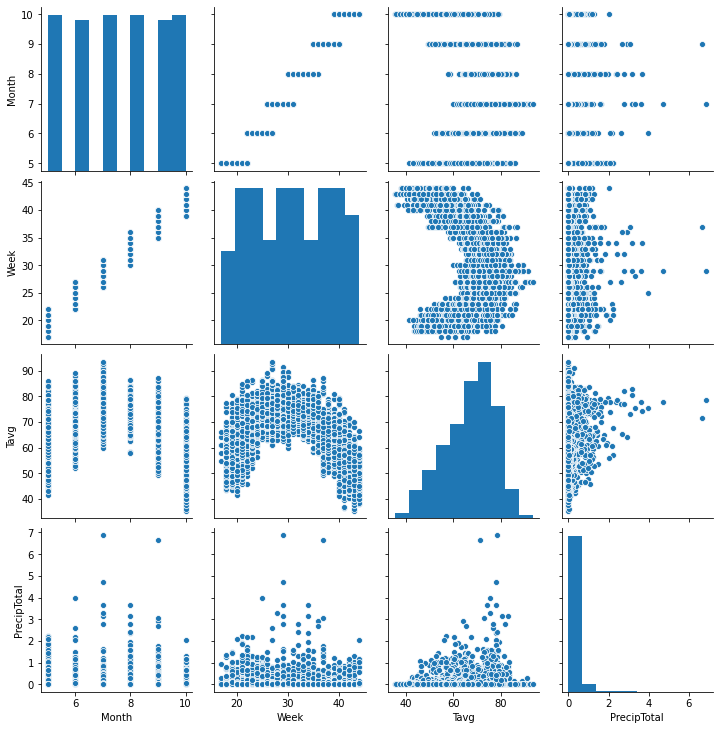

In [39]:
# A pairplot showing the scatter plots of temperature and precipitation against the time variables month and week
sns.pairplot(weather[['Month','Week','Tavg', 'PrecipTotal']])

In [40]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,relative_humidity,Trange,Year,Month,Week,Day,precip_7D_avg
0,1,2007-05-01,83,50,66.5,51,56,0.0,57,33,2007,5,18,1,0.0
1,2,2007-05-01,84,52,68.0,51,57,0.0,55,32,2007,5,18,1,0.0
2,1,2007-05-02,59,42,50.5,42,47,0.0,55,17,2007,5,18,2,0.0
3,2,2007-05-02,60,43,51.5,42,47,0.0,52,17,2007,5,18,2,0.0
4,1,2007-05-03,66,46,56.0,40,48,0.0,35,20,2007,5,18,3,0.0


In [41]:
weather.to_csv('../Assets/weather_cleaned.csv', index=False)